# PCA analysis of the llama3 embeddings

In [35]:
from pathlib import Path
from dataclasses import dataclass, fields, asdict

import numpy as np
import h5py
import scipy.stats
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
# Set the file name (required)
__file__ = "testing.ipynb"

# Add ipython magics
# Add ipython magics
import ipytest
import pytest


ipytest.autoconfig()

## read model and weights

In [3]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [5]:
e = model.get_input_embeddings().weight.detach().numpy()
e.shape

(128256, 4096)

## compute embeddings PCA

In [6]:
nc = 4096
bs = 100000
model_embedding_key = model_id.split('/')[1]

In [7]:
@dataclass
class EmbeddingsPCA:
    singular_values: np.ndarray
    explained_variance_ratio: np.ndarray
    explained_variance: np.ndarray
    components: np.ndarray
    mean: np.ndarray
    cov: np.ndarray

    @classmethod
    def load(cls, fn: Path) -> 'EmbeddingsPCA':
        """Load the embeddings PCA from file."""
        with h5py.File(fn, 'r') as hf:
            items = {}
            for key in fields(cls):
                items[key.name] = hf[key.name][:]
            return EmbeddingsPCA(**items)

    def save(self, fn: Path) -> None:
        """Save the embeddings PCA to file."""
        with h5py.File(fn, 'w') as hf:
            for key, value in asdict(self).items():
                hf.create_dataset(key, data=value)

In [8]:
%%ipytest

def test_embeddings_pca_load_save(tmp_path):
    data = {field.name: np.random.randn(3, 4) for field in fields(EmbeddingsPCA)}
    f = tmp_path.joinpath("test_embeddings_pca_load_save.npz")
    x = EmbeddingsPCA(**data)
    x.save(f)
    y = EmbeddingsPCA.load(f)
    for key, value in asdict(y).items():
        np.testing.assert_array_equal(value, data[key])

.                                                                                            [100%]
1 passed in 0.01s


In [9]:
def get_embeddings_pca(emb, nc: int, model_key: str, data_dir: Path | None = None, force: bool = False) -> EmbeddingsPCA:
    data_dir = data_dir or Path("data")
    fn = data_dir.joinpath(f"{model_embedding_key}-embeddings-pca_{nc}.npz")
    if force or not fn.exists():
        sk_pca = PCA(n_components=nc)
        x = sk_pca.fit(e)
        pca = EmbeddingsPCA(
            singular_values=sk_pca.singular_values_,
            explained_variance=sk_pca.explained_variance_,
            explained_variance_ratio=sk_pca.explained_variance_ratio_,
            components=sk_pca.components_,
            mean=sk_pca.mean_,
            cov=sk_pca.get_covariance(),
        )
        pca.save(fn)
        return pca
    else:
        return EmbeddingsPCA.load(fn)

In [10]:
ep = get_embeddings_pca(e, nc, model_key=model_embedding_key)

### validation: use explicit SVD

In [11]:
e_mean = e.mean(axis=0)
e_centered = e - e_mean
u, s, vt = np.linalg.svd(e_centered, full_matrices=False)

In [12]:
print("u.shape = ", u.shape)
print("s.shape = ", s.shape)
print("vt.shape = ", vt.shape)

u.shape =  (128256, 4096)
s.shape =  (4096,)
vt.shape =  (4096, 4096)


In [22]:
f = u * s[None, :] + e_mean[None, :]  # tokens in the PC space
f.shape

(128256, 4096)

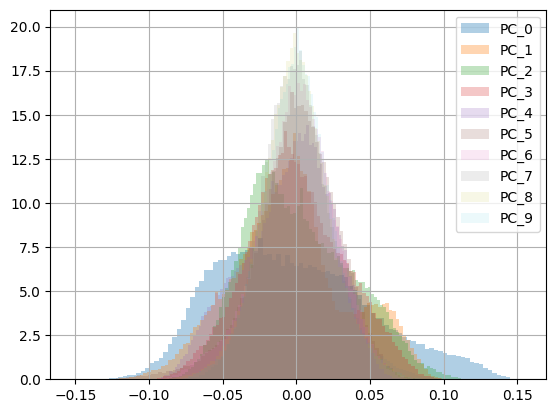

In [34]:
for i in range(10):
    plt.hist(f[:, i], bins=100, density=True, alpha=.35 - 0.03 * i, label=f"PC_{i}");
plt.legend()
plt.grid()

In [63]:
f_pdf = [scipy.stats.gaussian_kde(f[:, i]) for i in range(9)]

In [64]:
num_new_tokens = 1000
g = np.column_stack([f_pdf[i].resample(num_new_tokens)[0] for i in range(len(f_pdf))])

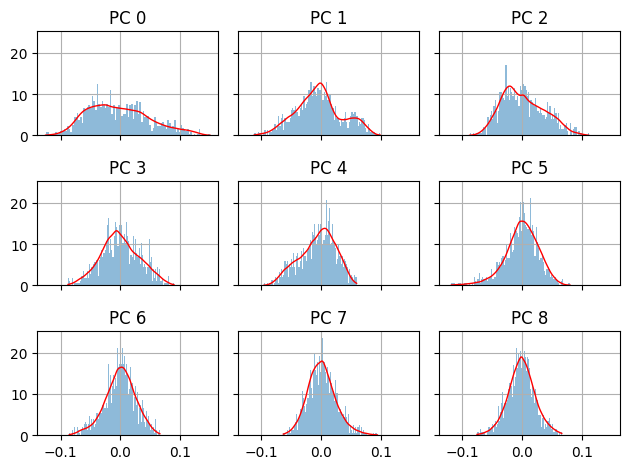

In [69]:
nrow, ncol = 3, 3
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, layout="tight")
for irow in range(nrow):
    for icol in range(ncol):
        i = irow * ncol + icol
        cnt, bins, p = ax[irow, icol].hist(g[:, i], bins=100, density=True, alpha=.5)
        ax[irow, icol].plot(bins, f_pdf[i](bins), 'r', lw=1)
        ax[irow, icol].set_title(f"PC {i }")
        ax[irow, icol].grid()

In [44]:
t = u * s[None, :]
y = t @ vt

check that $M = U \Sigma V^T$:

In [45]:
np.testing.assert_allclose(y - e, 0, atol=1e-7)

In [51]:
f = e @ vt.T
ss = f.T @ f

check that $\left( M V \right) ^T \left( M V \right) = \mathrm{diag} \left( \sigma_{i}^{2} \right)$:

In [65]:
np.testing.assert_allclose(ss - np.diag(np.diag(ss)), 0., atol=1e-4)
np.testing.assert_allclose(np.sqrt(np.diag(ss)), s, atol=1e-5)

In [50]:
np.set_printoptions(precision=3)
tcov[:5, :5]

array([[ 5.540e-04, -8.974e-04, -5.349e-05, -1.946e-05,  7.979e-05],
       [-8.974e-04,  2.262e-03, -7.553e-06, -2.748e-06,  1.127e-05],
       [-5.349e-05, -7.553e-06,  1.501e-03, -1.638e-07,  6.715e-07],
       [-1.946e-05, -2.748e-06, -1.638e-07,  1.265e-03,  2.444e-07],
       [ 7.979e-05,  1.127e-05,  6.715e-07,  2.444e-07,  1.052e-03]])

## embeddings in PC space

In [19]:
e_mean = e.mean(axis=0)
f = (e - ep.mean[None, :]) @ ep.components.T
f.shape

(128256, 4096)

In [20]:
f_cov = np.cov(f, rowvar=False)

In [21]:
f_cov[:3, :3]

array([[ 2.64812290e-03, -1.11973034e-09,  1.35575807e-10],
       [-1.11973034e-09,  1.50254728e-03, -1.03237051e-09],
       [ 1.35575807e-10, -1.03237051e-09,  1.26516964e-03]])

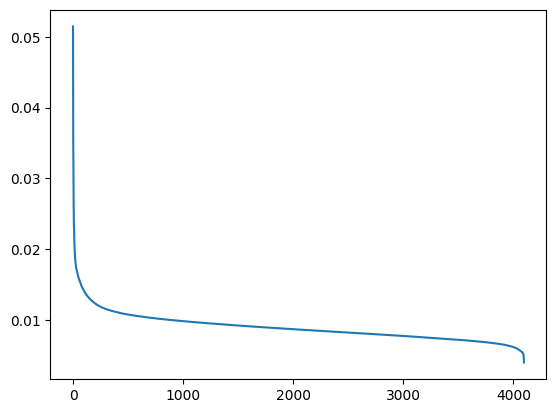

In [26]:
plt.plot(np.sqrt(np.diag(f_cov)))

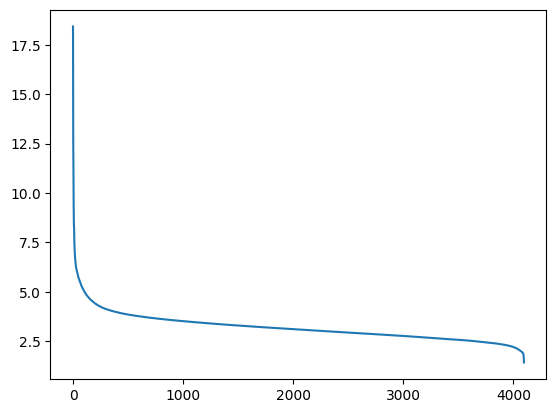

In [27]:
plt.plot(ep.singular_values)

In [32]:
ep = get_embeddings_pca(e, nc, model_key=model_embedding_key)

In [8]:
# ipca = IncrementalPCA(n_components=nc, batch_size=bs)
pca = IncrementalPCA(n_components=nc, whiten=True)

In [9]:
%%time
x = pca.fit(e)

CPU times: user 8h 22min 52s, sys: 9.8 s, total: 8h 23min 2s
Wall time: 16min 51s


In [10]:
import matplotlib.pyplot as plt

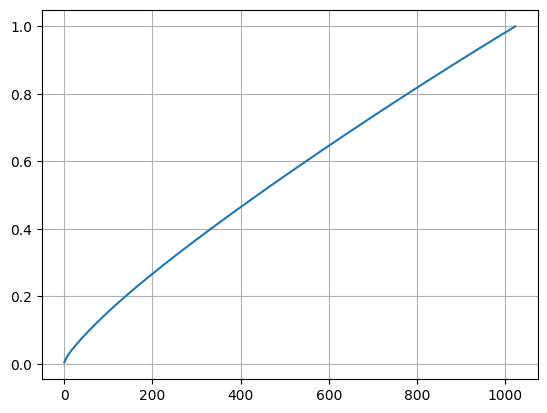

In [11]:
xsv = x.singular_values_
plt.plot(xsv.cumsum() / xsv.sum())
plt.grid()

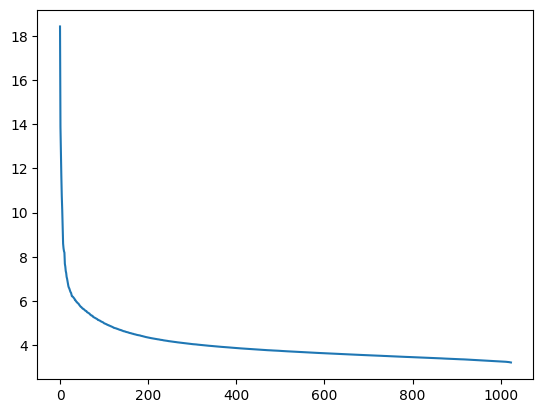

In [12]:
plt.plot(xsv)

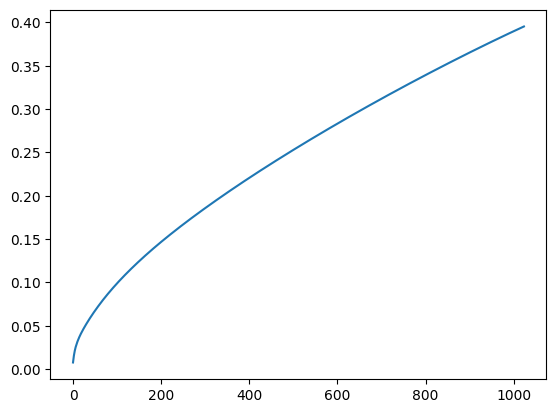

In [13]:
plt.plot(x.explained_variance_ratio_.cumsum())

In [14]:
import numpy as np

In [15]:
x.explained_variance_.shape

(1024,)

In [16]:
file_name = "data/llama-3-8B-embeddings-pca.npz"
np.savez(file_name, w=x.components_, v=x.singular_values_, explained_variance=x.explained_variance_, cov=x.get_covariance())

## Whiten initial embeddings

In [40]:
e0 = pca.transform(e)

In [42]:
e0_mean = e0.mean(axis=0)
e0_std = e0.std(axis=0)

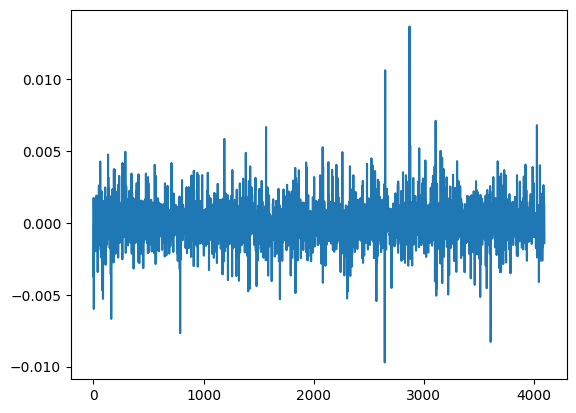

In [49]:
plt.plot(pca.mean_)

In [45]:
e0_mean.mean(), e0_std.mean()

(1.2801635446909194e-18, 1.0127001431002802)

# PCs to tokens

We look for the tokens for the embeddings close to the largest PCs

In [17]:
w = x.components_
v = x.singular_values_
e_norm = np.linalg.norm(e, ord=2, axis=1)
e_norm.shape

(128256,)

In [18]:
e_norm[:100]

array([0.38088042, 0.36046913, 0.43152985, 0.43763465, 0.46234465,
       0.468392  , 0.3601245 , 0.4035418 , 0.33167952, 0.40646577,
       0.42534167, 0.34591   , 0.36136338, 0.28659073, 0.40038288,
       0.36863896, 0.35557753, 0.35249707, 0.36204875, 0.36830747,
       0.37435922, 0.3768062 , 0.3848852 , 0.3855396 , 0.39663166,
       0.30792937, 0.34418097, 0.4696662 , 0.41829598, 0.42720845,
       0.36535677, 0.47816798, 0.33331335, 0.393552  , 0.38061604,
       0.3793039 , 0.35878208, 0.39277261, 0.39553586, 0.3985852 ,
       0.34090355, 0.41024095, 0.3893114 , 0.39639756, 0.38658598,
       0.3896957 , 0.3641221 , 0.3990515 , 0.44305703, 0.39376354,
       0.34589535, 0.38606423, 0.38960487, 0.4062526 , 0.40615433,
       0.39536786, 0.34343016, 0.39696005, 0.40793547, 0.3764236 ,
       0.37227532, 0.46288666, 0.4031896 , 0.4809818 , 0.31252596,
       0.37985277, 0.37338844, 0.3689316 , 0.33185953, 0.37912533,
       0.38392162, 0.37586376, 0.32263133, 0.40057364, 0.36262

Text(0.5, 1.0, 'pdf of the embedings norm')

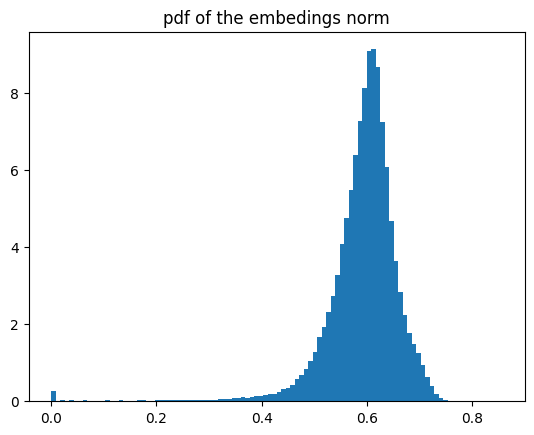

In [19]:
plt.hist(e_norm, bins=100, density=True)
plt.title("pdf of the embedings norm")

In [20]:
e_to_v = e - w[0]

In [21]:
de2 = np.linalg.norm(e_to_v, axis=1)
de2.shape

(128256,)

In [22]:
np.argpartition(de2, 20)[:20]

array([4857, 2115, 2955, 2410, 2447, 3495, 3838, 2532, 2349, 2585, 6975,
       1646, 4500, 1396, 6873, 8481, 4029, 1912, 8198, 2626])

In [23]:
tokenizer.decode(np.argpartition(de2, 20)[:20])

NameError: name 'tokenizer' is not defined

## statistical embeddings

we generate normally distributed $N\left(0,1)\right)$ embeddings, in the eigen-basis of the actual embedings, and convert them back to the original basis.

we then compare the distribution of the generated/converted embedings with the original ones.

In [59]:
f = np.random.randn(e.shape[0], pca.components_.shape[0])
f += pca.mean_[np.newaxis, :pca.components_.shape[0]]
f.shape

(128256, 1024)

In [60]:
ff = pca.inverse_transform(f)

In [61]:
f_norm = np.linalg.norm(ff, ord=2, axis=1)

Text(0.5, 1.0, 'pdf of the generated embedings norm')

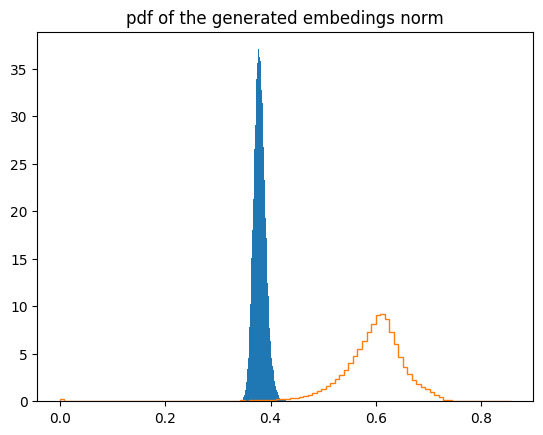

In [63]:
plt.hist(f_norm, bins=100, density=True)
plt.hist(e_norm, bins=100, density=True, histtype='step')
plt.title("pdf of the generated embedings norm")